## Parsing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rosseti_parser import RossetiParser

Parse Rosseti site or load data from csv

In [2]:
import os

file_path = './data.csv'

if os.path.isfile(file_path):
    parser = RossetiParser(file_path=file_path)
else:
    parser = RossetiParser()
    parser.save_df(file_path)

Read from "./data.csv"


In [3]:
print(parser)

From 2023-09-21 for 7 days with 296 records


In [4]:
df = parser.df

Parse street dataframe column and split row by it

In [5]:
from rosseti_parser import split_addresses

df = split_addresses(df)

df

index  ...                                        Комментарий
0         0  ...  В связи с производством оперативных переключен...
1         1  ...                                                NaN
2         1  ...                                                NaN
3         1  ...                                                NaN
4         1  ...                                                NaN
...     ...  ...                                                ...
1989    295  ...                                                NaN
1990    295  ...                                                NaN
1991    295  ...                                                NaN
1992    295  ...                                                NaN
1993    295  ...                                                NaN

[1994 rows x 12 columns]

Fetch `Building_ID` and coordinates from Geocoder API

In [6]:
from rosseti_parser import async_fetch_building_ids

file_path = 'data_with_building_id.csv'

if os.path.isfile(file_path):
    df = pd.read_csv(file_path)
else:
    df = await async_fetch_building_ids(df)
    df.to_csv('./data_with_building_id.csv', index=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 15 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   index                                                      1994 non-null   int64  
 1   Регион РФ (область, край, город фед. значения, округ)      1992 non-null   object 
 2   Административный район                                     1994 non-null   object 
 3   Населённый пункт                                           1994 non-null   object 
 4   Улица                                                      1865 non-null   object 
 5   Плановая дата начала отключения электроснабжения           1994 non-null   object 
 6   Плановое время начала отключения электроснабжения          1994 non-null   object 
 7   Плановая дата восстановления отключения электроснабжения   1994 non-null   object 
 8   Плановое

Run dataframe preprocessing

In [8]:
from rosseti_parser import preprocess_df, COL_NS, ICOL_NS, preprocess_read_df

file_path = 'data_preprocessed.csv'

if os.path.isfile(file_path):
    df = pd.read_csv(file_path)
    df = preprocess_read_df(df)
else:
    df = preprocess_df(df)
    df.to_csv('./data_preprocessed.csv', index=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        1994 non-null   int64         
 1   region       1992 non-null   object        
 2   area         1994 non-null   object        
 3   town         1994 non-null   object        
 4   street       1865 non-null   object        
 5   branch       1993 non-null   object        
 6   res          1993 non-null   object        
 7   comment      793 non-null    object        
 8   building_id  624 non-null    float64       
 9   lat          624 non-null    float64       
 10  lng          624 non-null    float64       
 11  start        1994 non-null   datetime64[ns]
 12  finish       1994 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(7)
memory usage: 202.6+ KB


Group dataframe rows by Rosseti table indexes 

In [10]:
from rosseti_parser import group_by_index

igr_df = group_by_index(df)

In [11]:
igr_df.head()

region  ...              finish
index                         ...                    
0      Ленинградская область  ... 2023-09-28 18:00:00
1            Санкт-Петербург  ... 2023-09-28 17:00:00
2      Ленинградская область  ... 2023-09-28 17:00:00
3            Санкт-Петербург  ... 2023-09-28 17:00:00
4            Санкт-Петербург  ... 2023-09-28 17:00:00

[5 rows x 12 columns]

In [12]:
igr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296 entries, 0 to 295
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   region       294 non-null    object        
 1   area         296 non-null    object        
 2   town         296 non-null    object        
 3   street       167 non-null    object        
 4   branch       295 non-null    object        
 5   res          295 non-null    object        
 6   comment      99 non-null     object        
 7   building_id  72 non-null     object        
 8   lat          72 non-null     object        
 9   lng          72 non-null     object        
 10  start        296 non-null    datetime64[ns]
 11  finish       296 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(10)
memory usage: 30.1+ KB


## Analysis

### Building fetching visualisation 

In [13]:
def print_percent(n):
    print(np.round(n * 100))

Percent of rows with street specified

In [14]:
igr_not_nan_street_df = igr_df[~pd.isnull(igr_df['street'])].copy()

not_nan_street = len(igr_not_nan_street_df)/len(igr_df)

print_percent(not_nan_street)

56.0


Percent of rows with at least one building found

In [15]:
@np.vectorize
def has_fetched_building_id(cell):
    return len(np.array(cell)[~pd.isnull(np.array(cell))]) > 0


not_nan_building_rows = len(igr_not_nan_street_df[
    has_fetched_building_id(igr_not_nan_street_df['building_id'])
]) / len(igr_not_nan_street_df)

print_percent(not_nan_building_rows)


43.0


Percent of street entities with found buildings

In [16]:
def count_found_building_percent(row: pd.Series):
    streets = np.array(row['street'])
    buildings = np.array(row['building_id'])

    buildings = buildings[~pd.isnull(buildings)]

    return len(buildings) / len(streets)


found_buildings_per_row = igr_not_nan_street_df[['street', 'building_id']].apply(
    count_found_building_percent, axis=1)

found_buildings = found_buildings_per_row.mean()
found_buildings_not_nan_street = found_buildings_per_row[found_buildings_per_row != 0].mean()

print_percent(found_buildings)

print_percent(found_buildings_not_nan_street)

30.0
69.0


<Axes: >

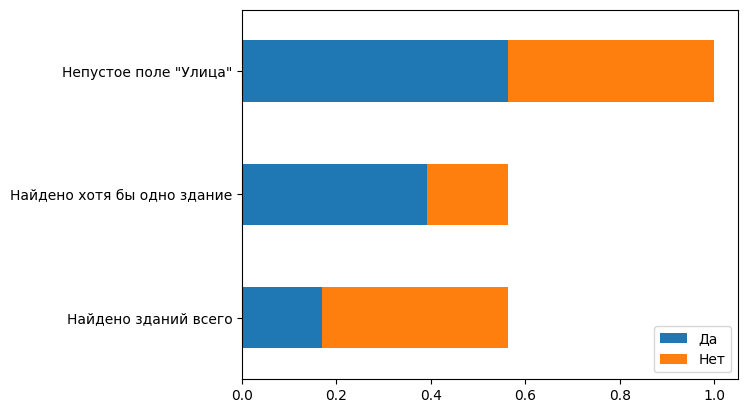

In [17]:
def full_pair(n):
    return np.array([n, 1 - n])


percents_df = pd.DataFrame({
    'Найдено зданий всего': full_pair(found_buildings) * not_nan_street,
    'Найдено хотя бы одно здание': full_pair(found_buildings_not_nan_street) * not_nan_street,
    'Непустое поле "Улица"': full_pair(not_nan_street),
}, index=['Да', 'Нет']).T

percents_df.plot(kind='barh', stacked=True)


In [18]:
igr_not_nan_street_df['found_building_percent'] = found_buildings_per_row

fb_area = igr_not_nan_street_df.groupby('area')['found_building_percent'].sum().sort_values(ascending=False)
fb_region = igr_not_nan_street_df.groupby('region')['found_building_percent'].sum().sort_values(ascending=False)
fb_town = igr_not_nan_street_df.groupby('town')['found_building_percent'].sum().sort_values(ascending=False)
fb_res = igr_not_nan_street_df.groupby('res')['found_building_percent'].sum().sort_values(ascending=False)

fb_town.loc['г. Санкт-Петербург'] += fb_town['Санкт-Петербург']
fb_town.drop('Санкт-Петербург', inplace=True)

fb_area = fb_area[~(fb_area == 0)]
fb_town = fb_town[~(fb_town == 0)]
fb_res = fb_res[~(fb_res == 0)]

for series in (fb_area, fb_region, fb_town, fb_res):
    display(series.head())

area
Приморский район (СПб)     9.681592
Курортный район            6.953731
Красногвардейский район    6.571429
Фрунзенский район          6.554798
Пушкинский район           5.998735
Name: found_building_percent, dtype: float64

region
Санкт-Петербург          49.110285
Ленинградская область     0.893617
Name: found_building_percent, dtype: float64

town
г. Санкт-Петербург               35.142893
г.Зеленогорск                     3.000000
г. Пушкин                         3.000000
г. Пушкин, п. Александровская     1.998735
п.Лисий Нос                       1.253731
Name: found_building_percent, dtype: float64

res
Западный РЭС      8.666667
Курортный РЭС     6.953731
Пушкинский РЭС    6.892352
Южный РЭС         5.333333
Невский РЭС       4.804798
Name: found_building_percent, dtype: float64

In [19]:
def plot_found_building_percent(df, name):
    fb_area_df = pd.DataFrame(df).rename(columns={
        'found_building_percent': 'Найдено зданий в ' + name
    })

    ax = fb_area_df.T.plot(kind='barh', stacked=True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks([])

    return ax

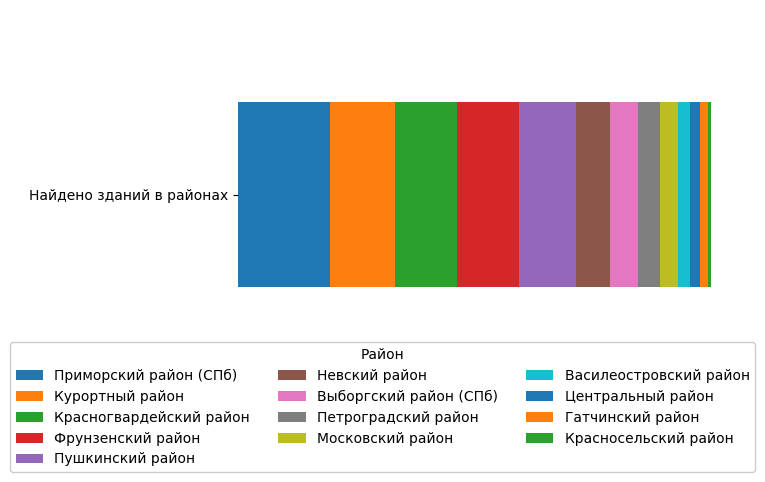

In [20]:
fb_area_ax = plot_found_building_percent(fb_area, 'районах')
fb_area_ax.legend(ncol=3, loc=(-0.46, -0.25), framealpha=1, title='Район')

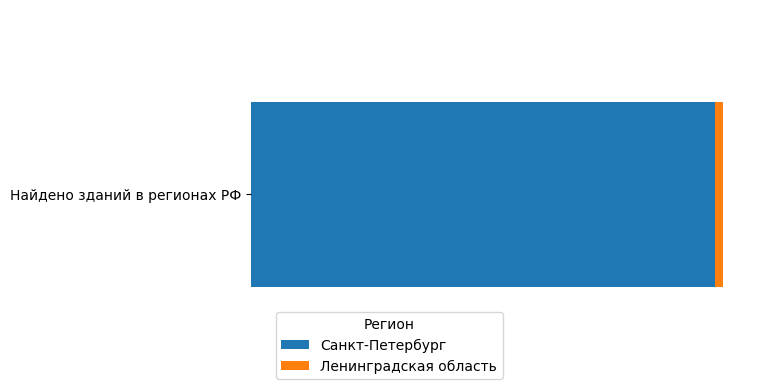

In [21]:
fb_region_ax = plot_found_building_percent(fb_region, 'регионах РФ')
fb_region_ax.legend(loc=(0.05, 0), title='Регион')

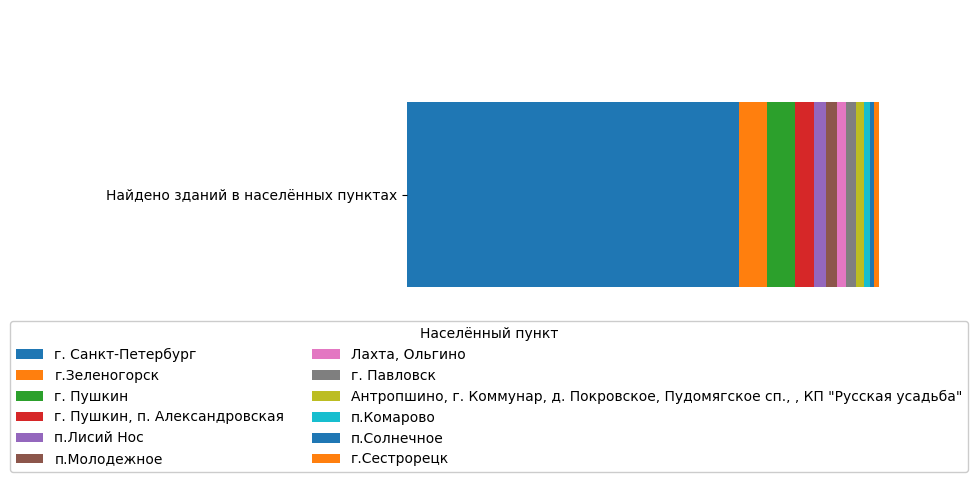

In [22]:
fb_town_ax = plot_found_building_percent(fb_town, 'населённых пунктах')
fb_town_ax.legend(ncol=2, loc=(-0.8, -0.25), framealpha=1, title='Населённый пункт')

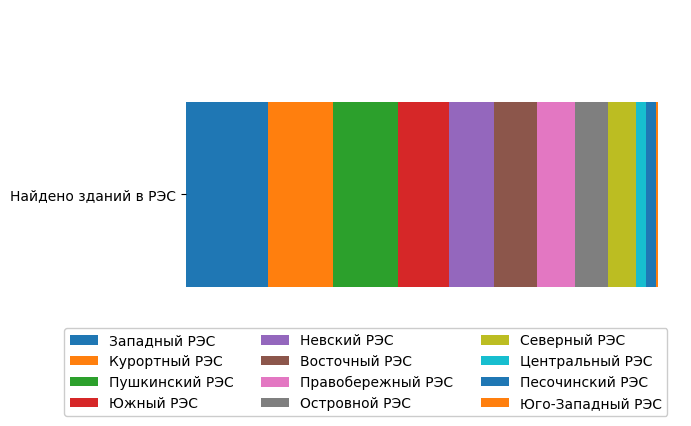

In [23]:
fb_res_ax = plot_found_building_percent(fb_res, 'РЭС')
fb_res_ax.legend(ncol=3, loc=(-0.245, -0.1), framealpha=1)

### Outage statistics

In [24]:
has_geo_df = df[pd.notnull(df['building_id'])].reset_index(drop=True)

has_geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        624 non-null    int64         
 1   region       624 non-null    object        
 2   area         624 non-null    object        
 3   town         624 non-null    object        
 4   street       624 non-null    object        
 5   branch       624 non-null    object        
 6   res          624 non-null    object        
 7   comment      320 non-null    object        
 8   building_id  624 non-null    float64       
 9   lat          624 non-null    float64       
 10  lng          624 non-null    float64       
 11  start        624 non-null    datetime64[ns]
 12  finish       624 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(7)
memory usage: 63.5+ KB


Distribution of outage by observation day

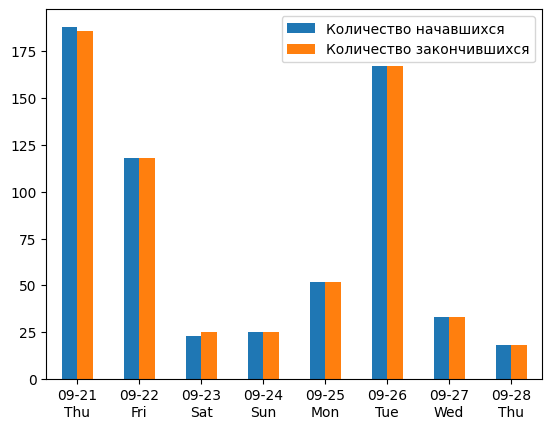

In [25]:
dates_df = pd.DataFrame(index=pd.to_datetime(np.unique(np.concatenate([has_geo_df[a].dt.date.unique() for a in ('start', 'finish')]))))

start_day_count = has_geo_df.groupby(has_geo_df['start'].dt.day).size()
finish_day_count = has_geo_df.groupby(has_geo_df['finish'].dt.day).size()

dates_df = dates_df.join(pd.Series(start_day_count, name='Количество начавшихся'), on=dates_df.index.day)

dates_df = dates_df.join(pd.Series(finish_day_count, name='Количество закончившихся'), on=dates_df.index.day)

ax = plt.subplot()

dates_df.plot(kind='bar', ax=ax)

ax.set_xticklabels(dates_df.index.strftime("%m-%d\n%a"))
ax.get_xaxis().set_tick_params(labelrotation=0)

Distribution of outage time by hour

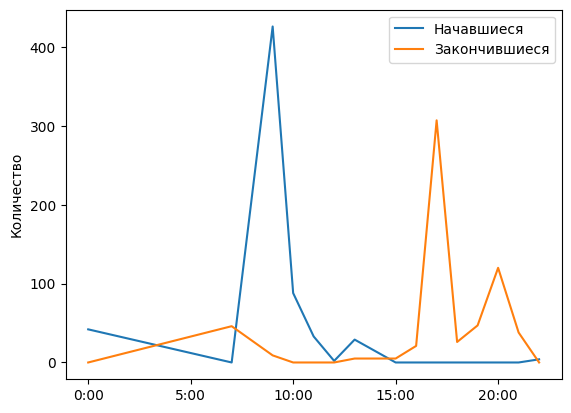

In [26]:
start_n = has_geo_df.groupby(has_geo_df['start'].dt.hour).size().rename('Начавшиеся')
finish_n = has_geo_df.groupby(has_geo_df['finish'].dt.hour).size().rename('Закончившиеся')

hrs_df = pd.concat([start_n, finish_n], axis=1, sort=True)

hrs_df.fillna(0, inplace=True)

hrs_df.plot()

xlim = plt.xlim()

plt.ylabel('Количество')
plt.gca().get_xaxis().set_major_formatter('{x:.0f}:00')

Number of outages in time

Text(0, 0.5, 'Количество')

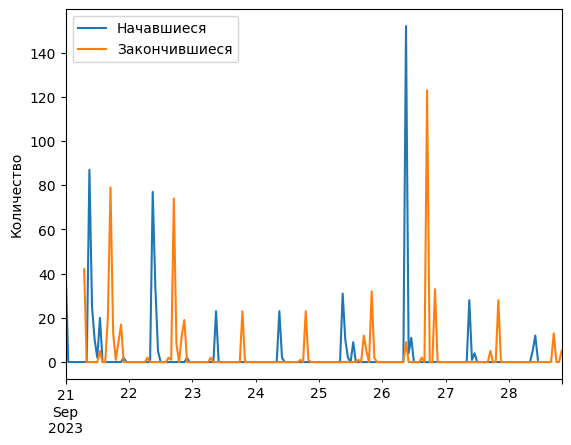

In [27]:
start_series = has_geo_df.resample('1H', on='start').size()
finish_series = has_geo_df.resample('1H', on='finish').size()

start_series.plot(label='Начавшиеся')
finish_series.plot(label='Закончившиеся')

plt.legend()
plt.xlabel('')
plt.ylabel('Количество')

Frequency representation

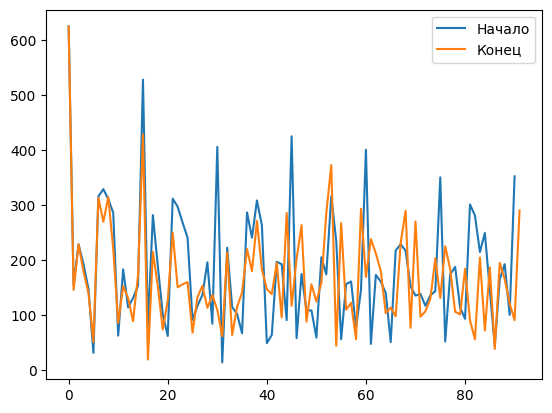

In [28]:
for series in (start_series, finish_series):
    plt.plot(abs(np.fft.rfft(series)))

plt.legend(('Начало', 'Конец'))

Number of simultanious outages

Text(0, 0.5, 'Количество одновременно отключённых')

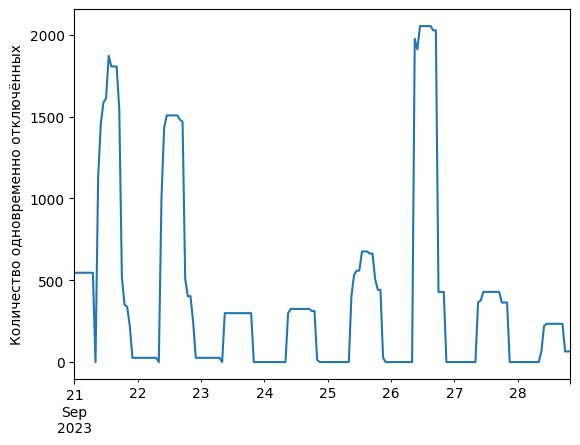

In [29]:
@np.vectorize
def count_inclusions(now):
    return has_geo_df[(has_geo_df['start'] <= now) & (now <= has_geo_df['finish'])].size


hours = pd.date_range(has_geo_df['start'].min(), has_geo_df['finish'].max(), freq='1H')

outages = count_inclusions(hours)

pd.DataFrame(outages, index=hours).plot()

plt.legend().set_visible(False)
plt.ylabel('Количество одновременно отключённых')

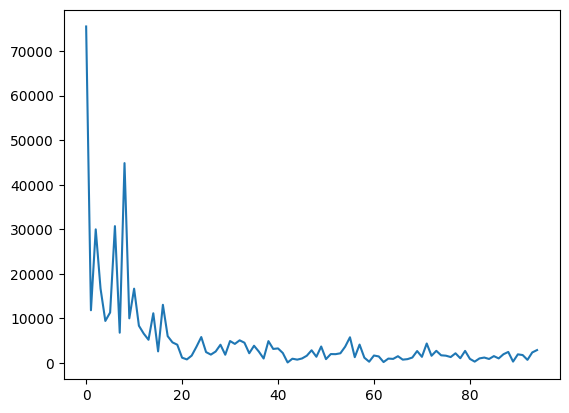

In [30]:
plt.plot(abs(np.fft.rfft(outages)))

Outages, that will last for more than a day

In [31]:
has_geo_df[has_geo_df['finish'] - has_geo_df['start'] > pd.Timedelta("1d")]

Empty DataFrame
Columns: [index, region, area, town, street, branch, res, comment, building_id, lat, lng, start, finish]
Index: []

Outages lengths distribution

Text(0, 0.5, 'Частота')

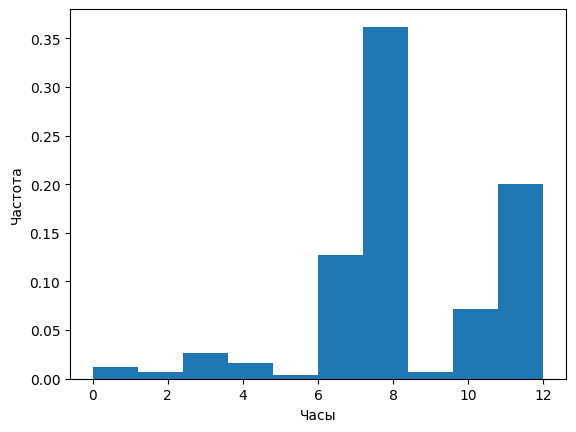

In [32]:
durations = (has_geo_df['finish'] - has_geo_df['start']) / pd.Timedelta('1H')

durations.plot(kind='hist', density=True)
plt.xlabel("Часы")
plt.ylabel("Частота")

Number of buildings where outages occur more than once

<Axes: >

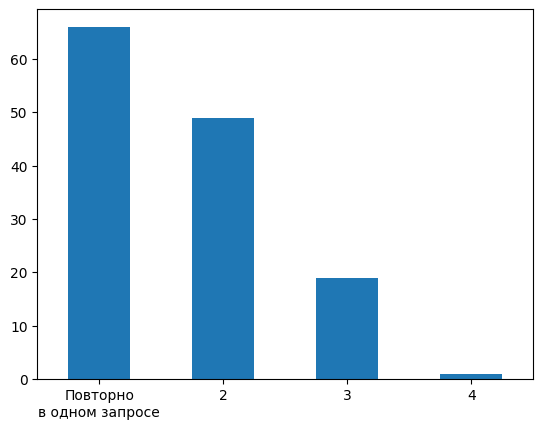

In [33]:
repeating_buildings = has_geo_df[has_geo_df.duplicated('building_id', keep=False)].drop_duplicates(['index', 'building_id']).groupby('building_id')

dups = repeating_buildings.size().value_counts()

dups.rename({1: 'Повторно\nв одном запросе'}, inplace=True)

dups.plot(kind='bar', rot=0)